## Import Dependencies

In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import os
from PIL import Image
import cv2
import albumentations as A
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

c:\Users\Sriram Kidambi\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Things to consider
- Data Augmentation
- Strong Loss Function (Cross-Entropy, Dice Loss, Jaccard(IoU))
- Start with U-Net Model

In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu" 

## Visualize an Image with Preprocessing

In [3]:
# Getting the list of the mask paths
list_mask_paths = []
for file in os.listdir(os.path.join("data", "Masks")):
    if "xml" in file:
        continue
    else:
        file_path = os.path.join("data", "Masks", file)
        list_mask_paths.append(file_path)

In [4]:
# Getting the list of the image paths
list_image_paths = []
for file in os.listdir(os.path.join("data", "Images")):
    if "xml" in file:
        continue
    else:
        file_path = os.path.join("data", "Images", file)
        list_image_paths.append(file_path)

In [5]:
# Getting list of image, mask pair
image_mask_list = list(zip(list_image_paths, list_mask_paths))

In [6]:
# Split into Train, Val, and Test images/masks
train_data, test_data = train_test_split(image_mask_list, train_size = 0.70, random_state = 42)
val_data, test_data = train_test_split(test_data, train_size = 0.50, random_state = 42)

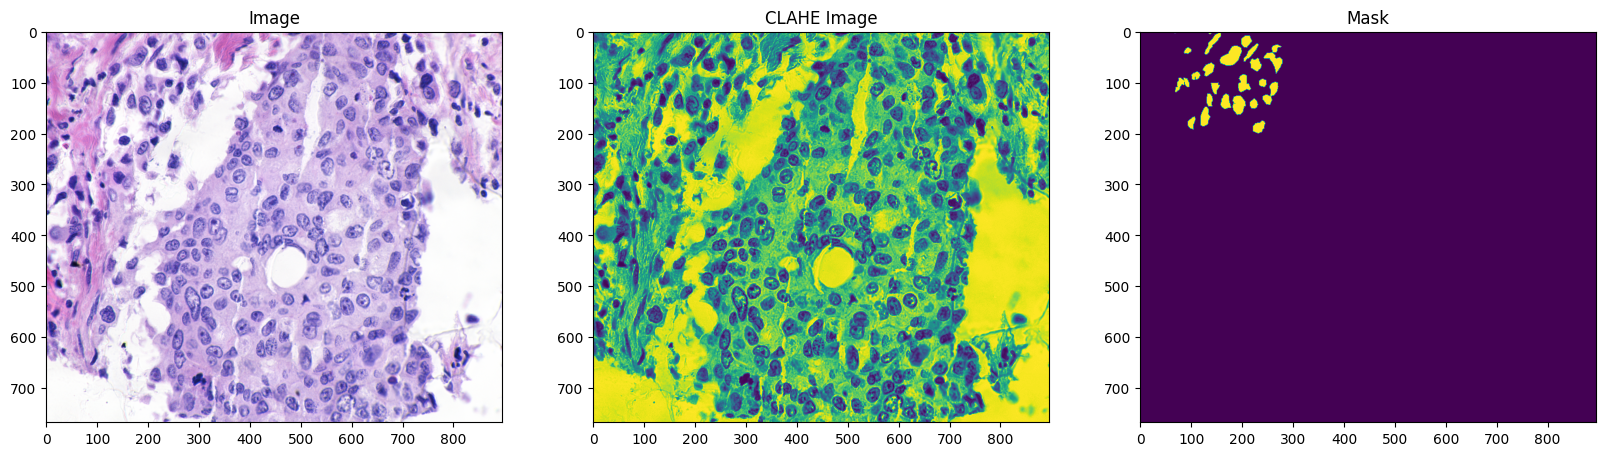

In [7]:
# Create subplot of cancer cell and mask
fig, axes = plt.subplots(1, 3, figsize = (20,10))
index = random.randint(0, len(image_mask_list)-1)
example_image_path, example_mask_path = image_mask_list[index]
example_image = Image.open(example_image_path).convert("RGB")
example_mask = Image.open(example_mask_path)

# Apply CLAHE to image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(np.array(example_image)[:, :, 0])

axes[0].imshow(example_image)
axes[0].set_title("Image")
axes[1].imshow(enhanced_image)
axes[1].set_title("CLAHE Image")
axes[2].imshow(example_mask)
axes[2].set_title("Mask")

plt.show()

In [8]:
# Find number of segmented pixels to background pixels ratio
index = random.randint(0, len(image_mask_list)-1)
_, example_mask_path = image_mask_list[index]
example_mask = np.array(Image.open(example_mask_path)) / 255

count_0 = np.sum(example_mask == 0).item()
count_1 = np.sum(example_mask == 1).item()

print(f"Count of pixels with value 0: {count_0}")
print(f"Count of pixels with value 1: {count_1}")

Count of pixels with value 0: 676697
Count of pixels with value 1: 11431


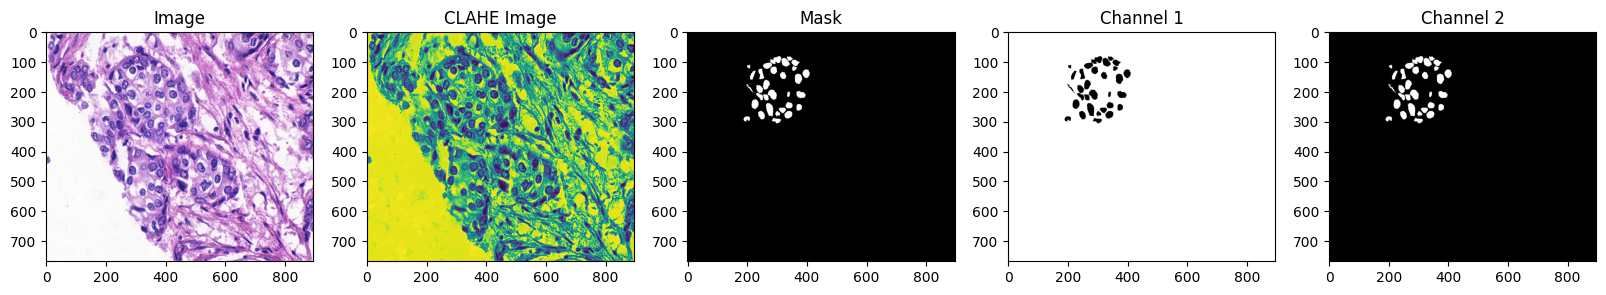

In [9]:
# Create subplot of cancer cell and mask with all preprocessing
fig, axes = plt.subplots(1, 5, figsize = (20,10))
index = random.randint(0, len(image_mask_list)-1)
example_image_path, example_mask_path = image_mask_list[index]
example_image = Image.open(example_image_path).convert("RGB")
example_mask = Image.open(example_mask_path)

# Apply CLAHE to image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(np.array(example_image)[:, :, 0])

# Apply mask encoding
example_mask = np.array(example_mask) / 255
num_classes = 2
encoded_mask = np.zeros((example_mask.shape[0], example_mask.shape[1], num_classes), dtype=np.uint8)

for class_index in range(num_classes):
    class_pixels = (example_mask == class_index)
    encoded_mask[:, :, class_index] = class_pixels

channel1 = encoded_mask[:, :, 0]
channel2 = encoded_mask[:, :, 1]

axes[0].imshow(example_image)
axes[0].set_title("Image")
axes[1].imshow(enhanced_image)
axes[1].set_title("CLAHE Image")
axes[2].imshow(example_mask, cmap = "gray")
axes[2].set_title("Mask")
axes[3].imshow(channel1, cmap = "gray")
axes[3].set_title("Channel 1")
axes[4].imshow(channel2, cmap = "gray")
axes[4].set_title("Channel 2")

plt.show()

## Creating Custom Mask and Image Transforms

In [10]:
# Apply One-hot encoding to mask
def mask_preprocessing(mask):
    mask = torch.permute(mask, [1, 2, 0])
    num_classes = 2
    encoded_mask = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)

    for class_index in range(num_classes):
        class_pixels = (mask == class_index).squeeze()
        encoded_mask[:, :, class_index] = class_pixels

    encoded_mask = torch.tensor(encoded_mask)
    encoded_mask = torch.permute(encoded_mask, [2, 0, 1])

    return encoded_mask

# Apply CLAHE to an image
def image_preprocessing(img, clip_limit, tile_grid_size):
    img_np = np.array(img)
    if len(img_np.shape) == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_np = clahe.apply(img_np)
    img = Image.fromarray(img_np)

    return img

In [11]:
# Create Custom Mask Transformations 
class MaskPreprocessing:
    def __init__(self):
        pass

    def __call__(self, mask):
        return mask_preprocessing(mask)

In [12]:
# Create Custom Image Transformations
class ImagePreprocessing:
    def __init__(self, clip_limit = 2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        return image_preprocessing(img, self.clip_limit, self.tile_grid_size)

## Crop Only the Region of Interest

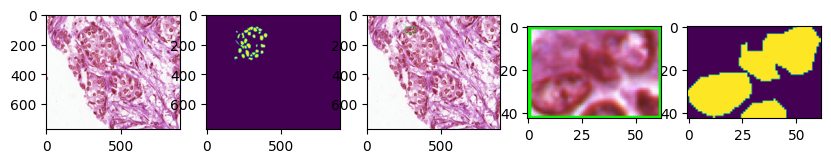

In [13]:
fig, axes = plt.subplots(1,5, figsize = (10,10))
mask = cv2.imread(example_mask_path, cv2.IMREAD_GRAYSCALE)
image = cv2.imread(example_image_path)
axes[0].imshow(image)
axes[1].imshow(mask)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    # Find the largest contour (assuming it corresponds to the ROI)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box around the largest contour
    x, y, width, height = cv2.boundingRect(largest_contour)

    # Crop the ROI from the original image
    roi = image[y:y+height, x:x+width]
    cropped_mask = mask[y:y+height, x:x+width]

    # Put the bounding box on the original image 
    bounded_img = cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    axes[2].imshow(bounded_img)
    # Save or further process the cropped ROI
    axes[3].imshow(roi)
    axes[4].imshow(cropped_mask)
else:
    print("No contours found in the mask.")

## Data Augmentation

In [14]:
augmentor = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p =0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ], p=0.5),
    A.OneOf([
            A.GaussNoise(p=0.5),
            A.Blur(blur_limit=3, p=0.5),
        ], p=0.5)
])

In [15]:
# Do Data Augmentation on Train Data
aug_images = []
aug_masks = []
for image_path, mask_path in train_data:
    for _ in range(50):
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        augmented = augmentor(image = image, mask = mask)
        aug_image = augmented["image"]
        aug_mask = augmented["mask"]
        aug_images.append(aug_image)
        aug_masks.append(aug_mask)
aug_train_data = list(zip(aug_images, aug_masks))
print(f"Increased Dataset size from {len(train_data)} to {len(aug_train_data)}")

Increased Dataset size from 40 to 2000


## Loading in the Dataset and the Masks 

In [16]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, data, mask_transform = None, image_transform = None):
        self.data = data
        self.mask_transform = mask_transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, mask_path = self.data[index]

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")   
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

In [17]:
# Custom Dataset for Augmented Data
class AugmentedSegmentationDataset(Dataset):
    def __init__(self, data, mask_transform = None, image_transform = None):
        self.data = data
        self.mask_transform = mask_transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, mask = self.data[index]
        
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

In [18]:
# Apply transformations
mask_transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                MaskPreprocessing()])

image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                ImagePreprocessing(),
                                transforms.ToTensor()])

In [19]:
# Loading in data into Train, Test, and Val Dataset
train_dataset = SegmentationDataset(train_data, mask_transform = mask_transform, image_transform = image_transform)
val_dataset = SegmentationDataset(val_data, mask_transform = mask_transform, image_transform = image_transform)
test_dataset = SegmentationDataset(test_data, mask_transform = mask_transform, image_transform = image_transform)

In [20]:
# Creating Train, Val, and Test DataLoaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle = False)

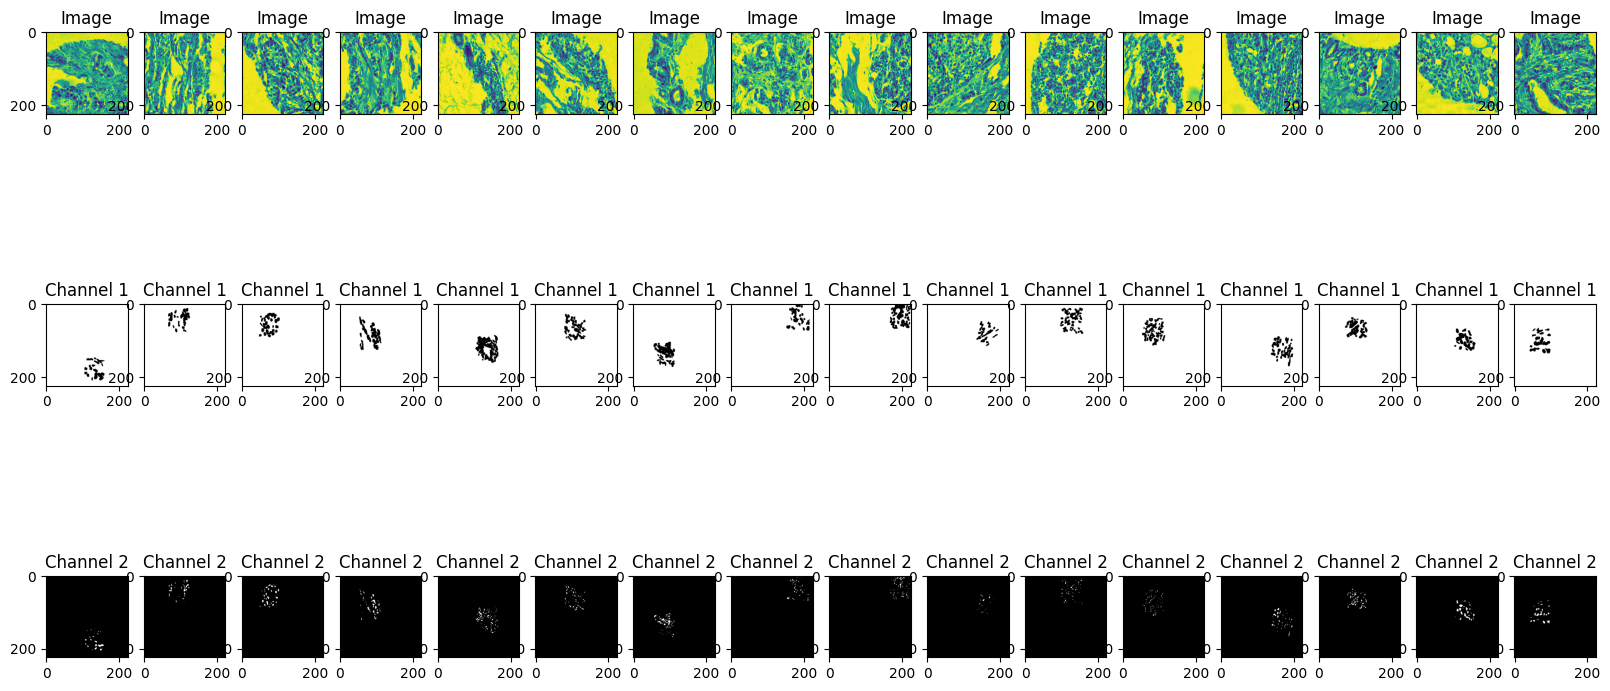

In [21]:
# Visualize a batch
image, mask = next(iter(train_dataloader))
fig, axes = plt.subplots(3, BATCH_SIZE, figsize = (20,10))
for j in range(BATCH_SIZE):
    permuted_mask = torch.permute(mask[j], [1, 2, 0])
    channel1 = permuted_mask[:, :, 0]
    channel2 = permuted_mask[:, :, 1]
    axes[0,j].imshow(torch.permute(image[j], [1, 2, 0]))
    axes[0,j].set_title("Image")
    axes[1,j].imshow(channel1, cmap = "gray")
    axes[1,j].set_title("Channel 1")
    axes[2,j].imshow(channel2, cmap = "gray")
    axes[2,j].set_title("Channel 2")

# Create the U-Net Model

In [22]:
# Create Double Convolutional Layers 
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.conv(x)

In [23]:
class UNET(nn.Module):
    # Input image dimension needs to be divisible by 16
    def __init__(self, in_channels = 1, out_channels = 2, features = [16, 32, 64, 128]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList() 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Down Part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size = 2, stride = 2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for index in range(0, len(self.ups), 2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index//2] 

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[index + 1](concat_skip)
        
        return self.final_conv(x)

In [24]:
# Create a test for the model to check if it is working
def test():
    x = torch.randn((3,1,160,160))
    model = UNET(in_channels = 1, out_channels = 2)
    preds = model(x)
    print(preds.shape)
    print(x.shape)

test()

torch.Size([3, 2, 160, 160])
torch.Size([3, 1, 160, 160])


## Using DeepLabV3

In [25]:
deeplab_model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in C:\Users\Sriram Kidambi/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Sriram Kidambi\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sriram Kidambi\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
deeplab_model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride = (2,2), padding=(3,3), bias=False)

In [27]:
deeplab_model.aux_classifier[4] = nn.Conv2d(256,2 , kernel_size=(1,1), stride=(1,1))

In [28]:
deeplab_model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [29]:
# Initialize a UNET model
model = UNET(in_channels = 1, out_channels = 2).to(device) # Send model to GPU

## Loss Function and Optimizer

- Try 3 different loss function
    - BCELoss
    - IoU Loss
    - Dice Loss

In [30]:
# Weighted Binary Cross Entropy Loss
class_weight = torch.tensor([1.0, 60.0]).to(device)
bce = nn.BCEWithLogitsLoss(weight = class_weight)

In [31]:
# Dice Loss
def dice_coefficient(predicted, target):
    smooth = 1e-5
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, predicted, target):
        dice = dice_coefficient(predicted, target)
        loss = 1.0 - dice
        return loss

dice_loss = DiceLoss()

In [32]:
## IoU Loss
class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predicted, target):
        predicted = predicted.view(-1)
        target = target.view(-1)
        intersection = (predicted * target).sum()
        union = predicted.sum() + target.sum() - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        loss = 1.0 - iou

        return loss
iou_loss = IoULoss()

In [33]:
## Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, class_weights = None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, inputs, targets):

        p = torch.sigmoid(inputs)

        # Compute the binary cross-entropy loss
        ce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute the modulating factor (1 - p)^gamma
        modulating_factor = (1 - p).pow(self.gamma)
        
        # Compute Class Weights
        if self.class_weights is not None:
            class_weights = self.class_weights.to(device)
            ce_loss = ce_loss * class_weights

        # Compute the final focal loss
        focal_loss = self.alpha * modulating_factor * ce_loss

        # Average the loss over the batch
        return focal_loss.mean()

class_weights = torch.tensor([1.0, 60.0])
focal_loss = FocalLoss(class_weights = class_weights)

In [34]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [35]:
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

## Training Step

In [38]:
def train_step(model, epochs, loss_fn, optimizer, train_dataloader, val_dataloader, scheduler=None):
    torch.cuda.manual_seed(42)
    history = { # Will add more metrics
        "Train Loss" : [],
        "Validation Loss": []
    }
    best_valid_loss = float('inf')
    patience = 5

    for epoch in range(epochs):
        train_loss = 0.0
        model.train()
        loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), leave = False)
        for batch, (X, y) in loop:
            X, y = X.to(device), y.to(device) # Send inputs to GPU

            y_pred = model(X) # Get a prediction

            y_pred = torch.permute(y_pred, [0, 2, 3, 1])
            y = torch.permute(y, [0, 2, 3, 1])
            
            loss = loss_fn(y_pred, y) # Calculate loss
            train_loss += loss

            optimizer.zero_grad() # Zero the gradients

            loss.backward() # Backpropagation

            optimizer.step() # Take GD Step

            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss = loss.item())

        train_loss /= len(train_dataloader)
        history["Train Loss"].append(train_loss)

        # Validation Step
        validation_loss = 0.0
        model.eval()
        with torch.inference_mode():
            val_loop = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave = False) 
            for batch, (X,y) in val_loop:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                print(y_pred)
                y_pred = torch.permute(y_pred, [0, 2, 3, 1])
                y = torch.permute(y, [0, 2, 3, 1])
    
                loss = loss_fn(y_pred, y)
                validation_loss += loss

                val_loop.set_description(f"Epoch [{epoch}/{epochs}]")
                val_loop.set_postfix(loss = loss.item())

            validation_loss /= len(val_dataloader)
            history["Validation Loss"].append(validation_loss)

        print(f"Epoch: {epoch} | Training Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}")

        # Check for early stopping and Model Checkpointing
        if validation_loss < best_valid_loss:
            # Save the model's parameters
            torch.save(model.state_dict(), os.path.join("best_models", "cancer_cell_segmentation_weights_deeplab.pth"))
            print("Model Checkpoint Triggered. Saving Best Model.")
            best_valid_loss = validation_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            return history
            
        if scheduler:
            scheduler.step()
    
    return history

In [40]:
# Train
EPOCHS = 60

history = train_step(deeplab_model, EPOCHS, bce, optimizer, train_dataloader, val_dataloader)

  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: permute(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

## Evaluating the Model

In [ ]:
# Load the best model
best_model = UNET(in_channels = 1, out_channels = 2)
best_model.load_state_dict(torch.load("best_models/cancer_cell_segmentation_weights_deeplab.pth"))

<All keys matched successfully>

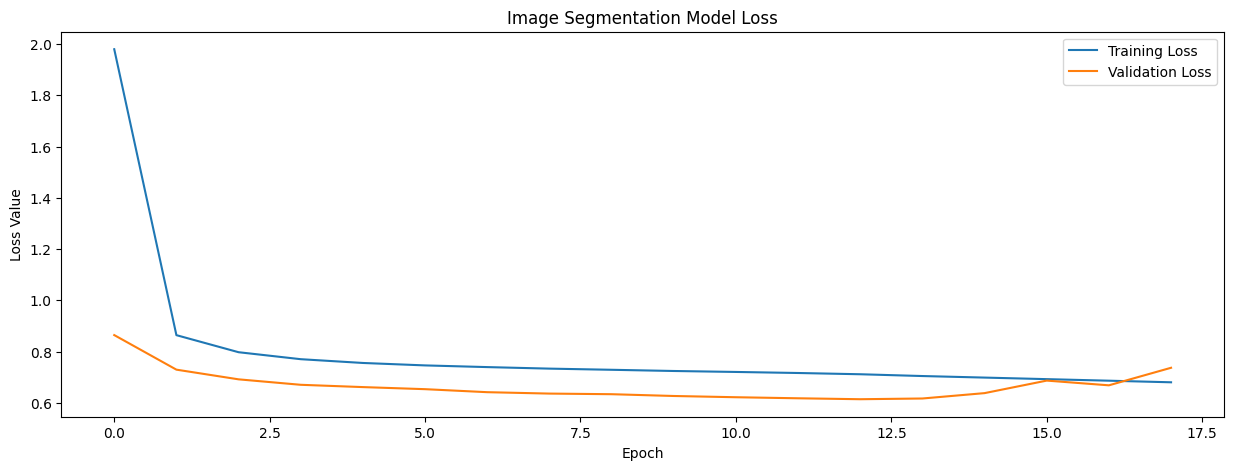

In [ ]:
# Plot Loss Values
plt.figure(figsize = (15,5))
plt.plot(torch.tensor(history["Train Loss"]).cpu(), label = "Training Loss")
plt.plot(torch.tensor(history["Validation Loss"]).cpu(), label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.title("Image Segmentation Model Loss")
plt.show()


In [ ]:
# Making Predictions
prediction_masks = []
best_model = best_model.to(device)

best_model.eval()
with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)

        y_logit = best_model(X)
        y_pred = torch.sigmoid(y_logit)
        prediction_masks.append(y_pred)
predictions_tensor = torch.cat(prediction_masks, dim = 0)

In [ ]:
# Collect all the test images
test_images = []
test_labels = []

for X, y in test_dataloader:
    test_images.append(X)
    test_labels.append(y)

test_images = torch.cat(test_images, dim = 0)
test_labels = torch.cat(test_labels, dim = 0)

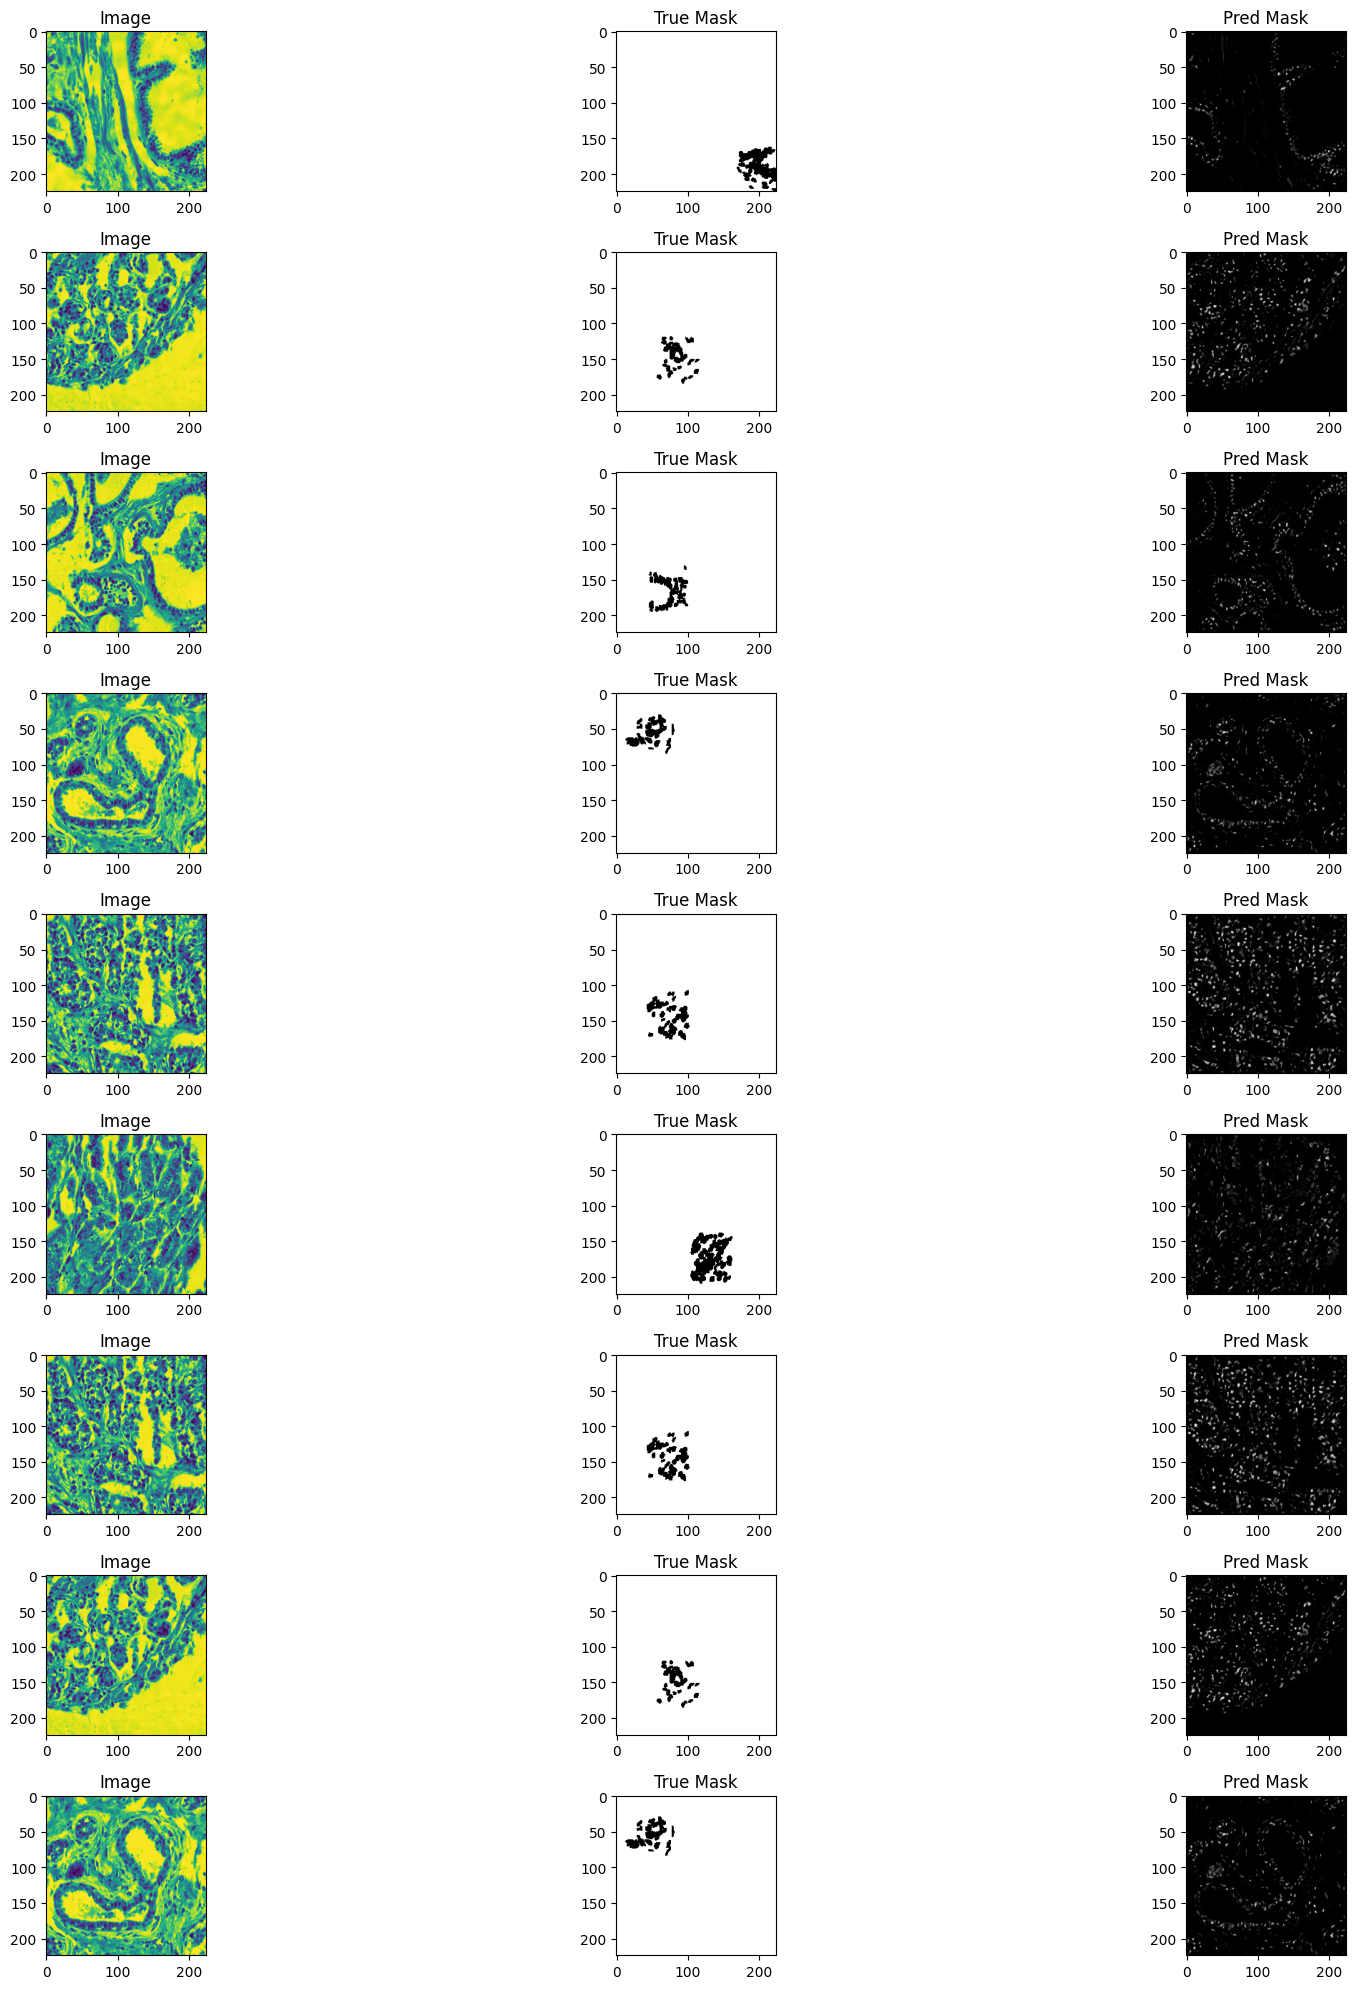

In [ ]:
num_figures = 9
fig, axes = plt.subplots(num_figures,3, figsize = (20,20))
for i in range(num_figures):
    index = random.randint(0, len(test_images)-1)
    image = torch.permute(test_images[index], [1, 2, 0])
    true_mask = test_labels[index][0,:,:]
    pred_mask = predictions_tensor[index][1,:,:].cpu()
    axes[i,0].imshow(image)
    axes[i,0].set_title("Image")
    axes[i,1].imshow(true_mask, cmap = "gray")
    axes[i,1].set_title("True Mask")
    axes[i,2].imshow(pred_mask, cmap = "gray")
    axes[i,2].set_title("Pred Mask")
plt.tight_layout()
plt.show()